# Lecture 06 - Good & Bad Controls

In [2]:
import sys, os
sys.path.append(os.path.abspath("../src"))  # make src importable

# Project modules
import init_notebook
import utils

# Third-party libs – explicit per notebook
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import xarray as xr
import graphviz as gr
import statsmodels.formula.api as smf

# Run the setup
init_notebook.setup()

Using style file: /Users/gharda/Documents/Code/statistical-rethinking-pymc/statistical-rethinking-pymc.mplstyle
Module aliases imported by init_notebook.py:
--------------------------------------------
import np
import pd
import smf
import pm
import xr
import az
import stats
import plt
import utils
Watermark:
----------
Last updated: 2025-12-26T13:13:29.931068+07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.7.0

Compiler    : Clang 17.0.0 (clang-1700.3.19.1)
OS          : Darwin
Release     : 25.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pathlib    : 1.0.1
matplotlib : 3.10.7
numpy      : 2.3.5
scipy      : 1.16.3
xarray     : 2025.11.0
pytensor   : 2.35.1
pymc       : 5.26.1
statsmodels: 0.14.5
pandas     : 2.3.3
arviz      : 0.22.0
watermark  : 2.5.0



# Avoid being clever at all costs

Being clever is
- unreliable
- opaque

Using explicit causal models allows one to:
- derive implications using logic
- verify work & assumptions
- facilitates peer review & verifications

# Confounds
## Review
- The Fork $X \leftarrow Z \rightarrow Y$
  - $X$ and $Y$ are associated unless we stratify by $Z$
- The Pipe $X \rightarrow Z \rightarrow Y$
  - $X$ and $Y$ are associated unless we stratify by $Z$
- The Fork $X \rightarrow Z \leftarrow Y$
  - $X$ and $Y$ are not associated unless we stratify by $Z$
- The Descendant $Z \rightarrow A$
  - Descendent $A$ takes on behavior of parent $Z$

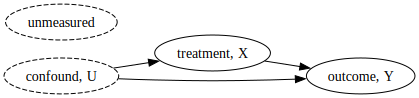

In [3]:
utils.draw_causal_graph(
    edge_list=[
        ("U", "X"),
        ("U", "Y"),
        ("X", "Y")
    ],
    node_props={
        "X": {"label": "treatment, X"},
        "Y": {"label": "outcome, Y"},
        "U": {"label": "confound, U", "style": "dashed"},
        "unmeasured": {"style": "dashed"}
    },
    graph_direction="LR"
)

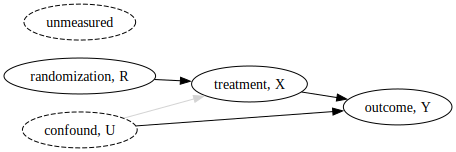

In [4]:
utils.draw_causal_graph(
    edge_list=[
        ("U", "X"),
        ("U", "Y"),
        ("X", "Y"),
        ("R", "X")
    ],
    node_props={
        "X": {"label": "treatment, X"},
        "Y": {"label": "outcome, Y"},
        "U": {"label": "confound, U", "style": "dashed"},
        "R": {"label": "randomization, R"},
        "unmeasured": {"style": "dashed"}
    },
    edge_props={
        ("U", "X"): {"color": 'lightgray'}
    },
    graph_direction="LR"
)

The gold standard is **Randomization**. However randomization often this generally isn't possible:
- impossible
- pragmatism
- ethical concerns
- unmeasured confounds

## Causal Thinking
- We would like a procedure $do(X)$ that intervenes on $X$ in such a way that it can "mimic" the effect of randomization.
- Such a procedure would transform the Confounded graph:

#### Without randomization

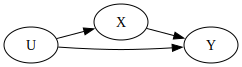

In [5]:
utils.draw_causal_graph(
    [
        ('U', 'X'),
        ('U', 'Y'),
        ('X', 'Y')
    ],
    graph_direction='LR'
)

in such a way that all the non-causal arrows entering X has been removed

#### With "randomization" induced by $do(X)$

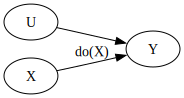

In [6]:
utils.draw_causal_graph(
    [
        ('U', 'Y'),
        ('X', 'Y'),
    ],
    edge_props={
        ('X', 'Y'): {'label': 'do(X)'}
    },
    graph_direction='LR'
)

It turns out that we can analyze graph structure to determine if there is such a procedure that exists

## Example: Simple Confound

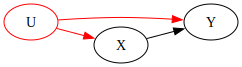

In [7]:
utils.draw_causal_graph(
    edge_list=[
        ('U', 'Y'),
        ('U', 'X'),
        ('X', 'Y'),
    ],
    node_props={
        'U': {'color': 'red'},
    },
    edge_props={
        ('U', 'X'): {'color': 'red'},
        ('U', 'Y'): {'color': 'red'}
    },
    graph_direction='LR'
)

In the Fork example, we've shown that stratifying by the confound, we "close" the fork by conditioning on U, thus removing any of the causal effect of U on X, thus allowing us to isolate the treatment's effect on Y.

This procedure is part of what is known as Do-calculus. The operator `do(X)` tends to mean intervening on X (i.e. setting it to a specific value that is independent of the confound)

$$ 
p(Y|\text{do}(X)) = \sum_U p(Y|X, U)p(U) = \mathbb{E}_U[p(Y | X, U)] 
$$

i.e. **the procedure that gives us the intervention on X is equivalent of the distribution of Y, stratified by the treatment X and the confound U, averaged over the distribution of the confound**

> Note that when we use linear regression estimator for each X, we are **implicitly marginalizing and averaging** over out treatment and confound (e.g. in the model form) $Y \sim \mathcal{N}(\alpha + \beta_X X + \beta_Z Z, \sigma^2)$

- it is generally **not the estimated coefficient** in the model that relate X to Y
- it is the distribution of Y when change X, **averaged over the distribution** defined by the control/confound variables (i.e. U)

## Do-calculus
- Applied to DAGs, provides a set of rules for identifying $p(Y|\text{do}(X))$
- **Informs what is possible** before picking functions or distributions
- **Justifies graphical analysis**
- If do-calculus claims that inference is possible no further special assumptions are required for inference
    - often additional assumptions can make the inference even stronger

## Backdoor Criterion
**Shortcut for applying Do-calculus graphically with your eyeballs**. General rule for finding the minimal sufficient adjustment set of variables to condition on.
1. Identify **all** paths connecting treatment X to outcome Y, including those entering and exiting X (association can be directed/undirected, causation is directed)
2. Any of those paths **entering X** are backdoor (non-causal) paths
3. Find the **adjustment set** of variables that, once conditioned on, "closes/blocks" all the backdoor paths identified in

#### Backdoor Criterion Example

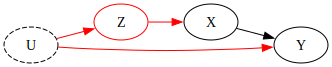

In [8]:
utils.draw_causal_graph(
    [
        ("U", "Z"),
        ("Z", "X"),
        ("U", "Y"),
        ("X", "Y")
    ],
    node_props={
        "Z": {"color": "red"},
        "U": {"style": "dashed"}
    },
    edge_props={
        ("U", "Z"): {"color": "red"},
        ("Z", "X"): {"color": "red"},
        ("U", "Y"): {"color": "red"}
    },
    graph_direction="LR"

)

Backdoor path highlighted in red.
- If we could measure $U$ we could just stratify by $U$; however, it is unobserved
- However, we can block the backdoor path by conditioning on $Z$, despite not being able to measure $U$.
- This works because $Z$ "knows" everything we need to know about association between $X$, $Y$ that is due to unmeasured confound $U$.

#### Resulting graph after stratifying by $Z$
- The $ U \rightarrow Z \rightarrow X $ Pipe has now been broken, disassociating $X$ from the confound $U$
- Note: this doesn't remove the confound's effect on $Y$

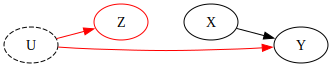

In [9]:
utils.draw_causal_graph(
    [
        ("U", "Z"),
        ("Z", "X"),
        ("U", "Y"),
        ("X", "Y")
    ],
    node_props={
        "Z": {"color": "red"},
        "U": {"style": "dashed"}
    },
    edge_props={
        ("U", "Z"): {"color": "red"},
        ("Z", "X"): {"color": "none"},
        ("U", "Y"): {"color": "red"}
    },
    graph_direction="LR"

)

### Validate through simulation

Here we simulate a situation where Y is caused by X and and an unmeasured confound U that also effects Z and X. (We could also prove mathematically, but simulation is quite convincing as well--for me anyways)

$$
\begin{align*}
U &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Normal}(\beta_{UZ}U, 1) \\
X &\sim \text{Normal}(\beta_{ZX}Z, 1) \\
Y &\sim \text{Normal}(\alpha + \beta_{XY}X + \beta_{UY}U, 1) \\
\end{align*}
$$

In [10]:
np.random.seed(123)
n_samples = 200

alpha = 0
beta_XY = 0
beta_UY = -1
beta_UZ = -1
beta_ZX = 1

U = stats.bernoulli.rvs(p=.5, size=n_samples)
Z = stats.norm.rvs(loc=beta_UZ * U)
X = stats.norm.rvs(loc=beta_ZX * Z)
Y = stats.norm.rvs(loc=alpha + beta_XY * X + beta_UY * U)

### Unstratified (confounded) Model


$$
\begin{align*}
Y &\sim \text{Normal}(\mu_Y, \sigma_Y) \\
\mu_Y &= \alpha + \beta_{XY}X \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{XY} &\sim \text{Normal}(0, 1) \\
\sigma_Y &\sim \text{Exponential}(1)
\end{align*}
$$

#### Fit the unstratified model, ignoring Z (and U)

In [11]:
with pm.Model() as unstratified_model:
    # Priors
    alpha_ = pm.Normal('alpha', 0, 1)
    beta_XY_ = pm.Normal('beta_XY', 0, 1)
    sigma_ = pm.Exponential('sigma', 1)
    
    # Likelihood
    mu_ = alpha_ + beta_XY_ * X
    Y_ = pm.Normal("Y", mu=mu_, sigma=sigma_, observed=Y)
    unstratified_model_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_XY, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [12]:
az.summary(unstratified_model_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.378,0.085,-0.542,-0.220,0.001,0.001,4349.0,3160.0,1.0
beta_XY,0.149,0.054,0.049,0.249,0.001,0.001,4015.0,3093.0,1.0
sigma,1.114,0.055,1.013,1.220,0.001,0.001,5190.0,3097.0,1.0


### Stratifying by Z (unconfounded)


$$
\begin{align*}
Y &\sim \text{Normal}(\mu_Y, \sigma_Y) \\
\mu_Y = &\alpha + \beta_{XY}X + \beta_{Z}Z \\
\alpha &\sim \text{Normal}(0, 1) \\
\beta_{*} &\sim \text{Normal}(0, 1) \\
\sigma_Y &\sim \text{Exponential}(1)
\end{align*}
$$

In [13]:
# Fit the stratified model
with pm.Model() as stratified_model:
    # Priors
    alpha_ = pm.Normal('alpha', 0, 1)
    beta_XY_ = pm.Normal('beta_XY', 0, 1)
    beta_Z_ = pm.Normal('beta_Z', 0, 1)
    sigma_ = pm.Exponential('sigma', 1)
    
    # Likelhiood (includes Z)
    mu_ = alpha_ + beta_XY_ * X + beta_Z_ * Z
    Y_ = pm.Normal("Y", mu=mu_, sigma=sigma_, observed=Y)
    stratified_model_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_XY, beta_Z, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
az.summary(stratified_model_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.285,0.088,-0.443,-0.111,0.002,0.001,3399.0,2611.0,1.0
beta_XY,-0.025,0.078,-0.169,0.123,0.001,0.001,3069.0,2785.0,1.0
beta_Z,0.317,0.103,0.126,0.509,0.002,0.002,3026.0,2610.0,1.0
sigma,1.092,0.056,0.988,1.200,0.001,0.001,3667.0,2793.0,1.0


**NOTE**: the model coefficient `beta_Z` means nothing in in terms of causal effect of $Z$ on $Y$. In order to determine the causal effect of $Z$ on $Y$ you'd need a different estimator. In general, variables in the adjustment set are not interpretable. This is related to the "Table 2 Fallacy"

#### Compare stratified and unstratified models

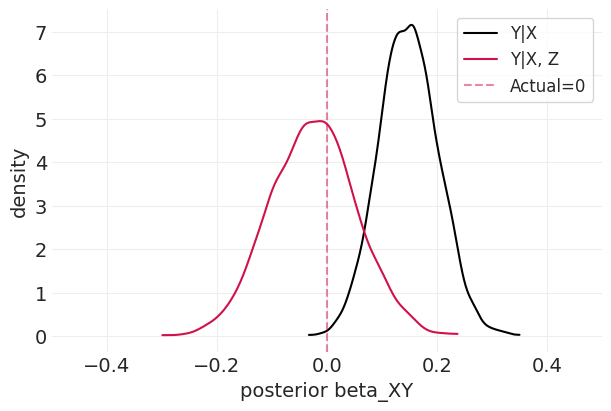

In [18]:
_, ax = plt.subplots(figsize=(6, 4))

az.plot_dist(unstratified_model_inference.posterior.beta_XY, color='k', label='Y|X', ax=ax)
az.plot_dist(stratified_model_inference.posterior.beta_XY, color='C0', label='Y|X, Z', ax=ax)
plt.axvline(beta_XY, color='C0', linestyle='--', alpha=.5, label=f"Actual={beta_XY}")
plt.xlim([-.5, .5])
plt.xlabel('posterior beta_XY')
plt.ylabel('density')
plt.legend();

## More Complicated Example

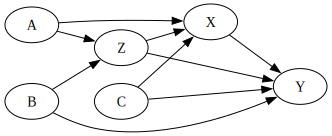

In [19]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    graph_direction="LR"
)


### All Paths Connecting X to Y

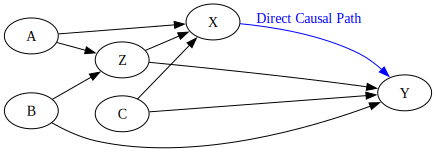

In [20]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("X", "Y"): {"color": "blue", "label": "Direct Causal Path", "fontcolor": "blue"},
    },
    graph_direction="LR"
)

#### $X \rightarrow Y$
- Direct, causal path, leave open

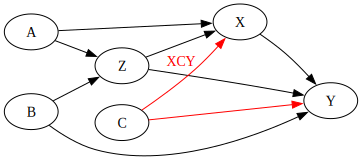

In [21]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("C", "X"): {"color": "red", "label": "XCY", "fontcolor": "red"},
        ("C", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

#### $X \leftarrow C \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $C$**

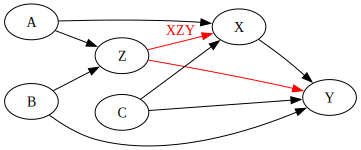

In [22]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("Z", "X"): {"color": "red", "label": "XZY", "fontcolor": "red"},
        ("Z", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

#### $X \leftarrow Z \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $Z$**

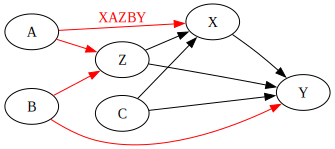

In [23]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("A", "X"): {"color": "red", "label": "XAZBY", "fontcolor": "red"},
        ("A", "Z"): {"color": "red"},
        ("B", "Z"): {"color": "red"},
        ("B", "Y"): {"color": "red"},
        
    },
    graph_direction="LR"
)

#### $X \leftarrow A \rightarrow Z \leftarrow B \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $A$ or $B$**; stratifying by $Z$ opens the path b.c. it's a collider
  - we're already stratifying by $Z$ for the $X,Z,Y$ backdoor path

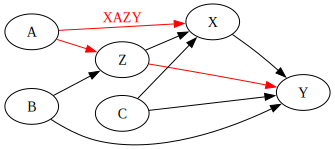

In [24]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("A", "X"): {"color": "red", "label": "XAZY", "fontcolor": "red"},
        ("A", "Z"): {"color": "red"},
        ("Z", "Y"): {"color": "red"},
        ("Z", "Y"): {"color": "red"},
        
    },
    graph_direction="LR"
)

#### $X \leftarrow A \rightarrow Z \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $A$;** stratifying by $Z$ opens the path b.c. it's a collider
  - we're already stratifying by $Z$ for the $X \leftarrow Z \rightarrow Y$ backdoor path

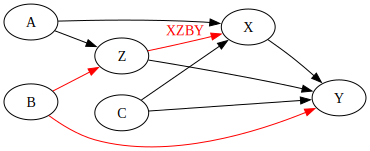

In [25]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "Z"),
        ("A", "X"),
        ("Z", "X"),
        ("B", "Z"),
        ("B", "Y"),
        ("Z", "Y"),
        ("X", "Y"),
        ("C", "X"),
        ("C", "Y")
    ],
    edge_props={
        ("Z", "X"): {"color": "red", "label": "XZBY", "fontcolor": "red"},
        ("B", "Z"): {"color": "red"},
        ("B", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

#### $X \leftarrow Z \leftarrow B \rightarrow Y$
- Backdoor non-causal path
- Block by **stratifying by $B$**; stratifying by $Z$ opens the path b.c. it's a collider
  - we're already stratifying by $Z$ for the $X \leftarrow Z \rightarrow Y$ backdoor path

#### Resulting Minimum Adjustment set: Z, C, (A or B)
Chossing B over A turns out to be more statistically efficient, though not causally different than choosing A

## Example with unobserved confounds

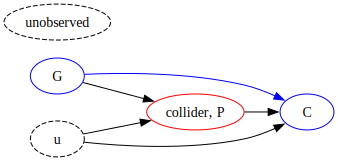

In [26]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "P"),
        ("P", "C"),
        ("G", "C"),
        ("u", "P"),
        ("u", "C")
    ],
    node_props={
        "G": {"color": "blue"},
        "C": {"color": "blue"},
        "P": {"color": "red", "label": "collider, P"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    edge_props={
        ("G", "C"): {"color": "blue"}
    },
    graph_direction="LR"
)

- $P$ is mediator between $G$ and $C$
- $P$ is also a collider between $G$, $u$, $C$
- If we want to estimate direct effect of $G \rightarrow C$, we'll need to stratify by $P$--close the Pipe
- However, this will open up the Collider path to the unobserved confound
- **It's not possible to accurately estimate the *Direct Causal Effect* of G on C**
- It **is possible to estimate the *Total Causal Effect***

# Good and bad controls

## Common _incorrect_ heuristics for choosing control variables:

- YOLO approach -- anything in the spreadsheet
- Ignore highly colinear variables
  - false, no support for this
  - colinearity can arise through many different causal processes that _can be modeled accurately_
- It's safe to add pre-treatment variables
  - false, pre-treatment, just like post-treatment variables can cause confounds.

## Good & Bad Controls Examples

### Bad control

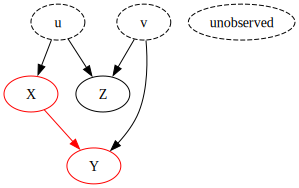

In [27]:
utils.draw_causal_graph(
    edge_list=[
        ("u", "Z"),
        ("v", "Z"),
        ("u", "X"),
        ("X", 'Y'),
        ("v", "Y")
    ],
    node_props={
        "u": {"style": "dashed"},
        "v": {"style": "dashed"},
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    },
    graph_direction="TD"
)

$Z$ is a collider for unobserved variables $u$ and $v$, which independently affect $X$ and $Y$
#### List the paths
- $X \rightarrow Y$
  - causal, leave open
- $X \leftarrow u \rightarrow Z \leftarrow v \rightarrow Y$
  - backdoor, closed due to collider
  - $Z$ is a **bad control**: stratifying by $Z$ would open the backdoor path
  - $Z$ could be a pre-treatment variable -- not always good to stratify by pre-treatment variables; **draw your causal assumptions**

### Bad mediator

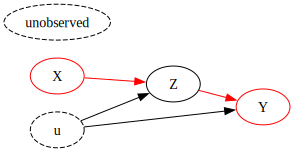

In [28]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y"),
        ("u", "Z"),
        ("u", "Y"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Z"): {"color": "red"},
        ("Z", "Y"): {"color": "red"}
    },
    graph_direction='LR'
)

#### List the paths
- $X \rightarrow Z \rightarrow Y$
  - causal, leave open
- $X \rightarrow Z \leftarrow u \rightarrow Y$
  - backdoor, but only if stratifying by Z
- There **is no backdoor path, so no need to stratify by Z**
- Can measure total effect of $X$ on $Y$, but not direct effect, because of Mediatior $Z$

No backdoor path here, so no need to control for any confounds. In fact, stratifying by `Z` (the bad mediator) will introduce bias in estimate because it introduces the causal effect of `u` that would otherwise be blocked.

`Z` is often a post-treatment variable, e.g. below, where "Happiness" is affected by the treatment "Win Lottery"

### Verify bad mediatior with simulation:

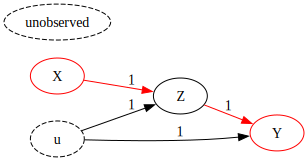

In [29]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y"),
        ("u", "Z"),
        ("u", "Y"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Z"): {"color": "red", "label": "1"},
        ("Z", "Y"): {"color": "red", "label": "1"},
        ("u", "Z"): {"label": "1"},
        ("u", "Y"): {"label": "1"}
    },
    graph_direction='LR'
)

In [30]:
def simulate_bad_mediator(beta_XZ, beta_ZY, n_samples=100):
    # independent variables
    u = stats.norm.rvs(size=n_samples)
    X = stats.norm.rvs(size=n_samples)
    
    # causal effect of X on Z
    mu_Z = X * beta_XZ + u
    Z = stats.norm.rvs(size=n_samples, loc=mu_Z)
    
    # causal effect of Z on Y (including confound)
    mu_Y = Z * beta_ZY + u
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)
    
    # put data into format for statsmodels
    data = pd.DataFrame(
        np.vstack([Y, X, Z, u]).T,
        columns = ['Y', 'X', 'Z', 'u']
    )
    
    unstratified_model = smf.ols('Y ~ X', data=data).fit()
    stratified_model = smf.ols('Y ~ X + Z', data=data).fit()
    
    return unstratified_model.params.X, stratified_model.params.X

def run_bad_mediator_simulation(beta_XZ=1, beta_ZY=1, n_simulations=500, n_samples_per_simulation=100):
    beta_X = beta_XZ * beta_ZY
    
    simulations = np.array(
        [
            simulate_bad_mediator(beta_XZ=beta_XZ, beta_ZY=beta_ZY, n_samples=n_samples_per_simulation)
            for _ in range(n_simulations)        
        ]
    )
    
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color='C0', ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f"actual={beta_X}")
    plt.legend(loc='upper left')
    plt.xlabel('posterior mean')
    plt.ylabel('density');

#### Run the simulation, $\beta_{XZ} = \beta_{ZY} = 1$ 

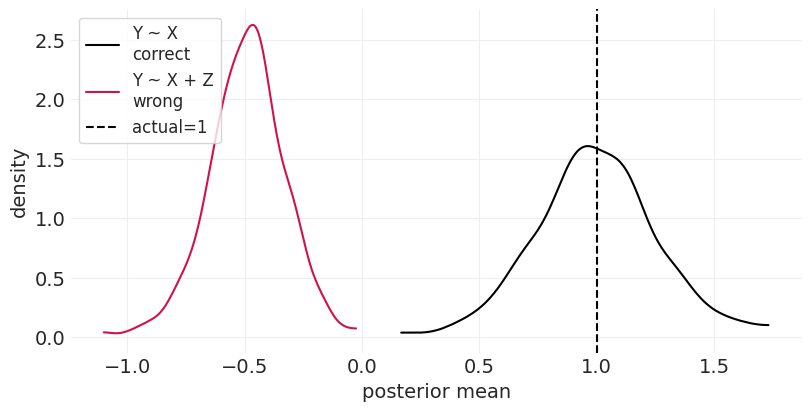

In [31]:
run_bad_mediator_simulation(beta_XZ = 1, beta_ZY=1)

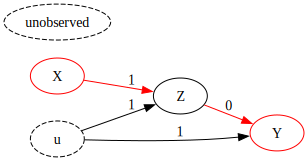

In [32]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y"),
        ("u", "Z"),
        ("u", "Y"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Z"): {"color": "red", "label": "1"},
        ("Z", "Y"): {"color": "red", "label": "0"},
        ("u", "Z"): {"label": "1"},
        ("u", "Y"): {"label": "1"}
    },
    graph_direction='LR'
)

#### Turn off Causal effect by changing $\beta_{ZY}$ to 0

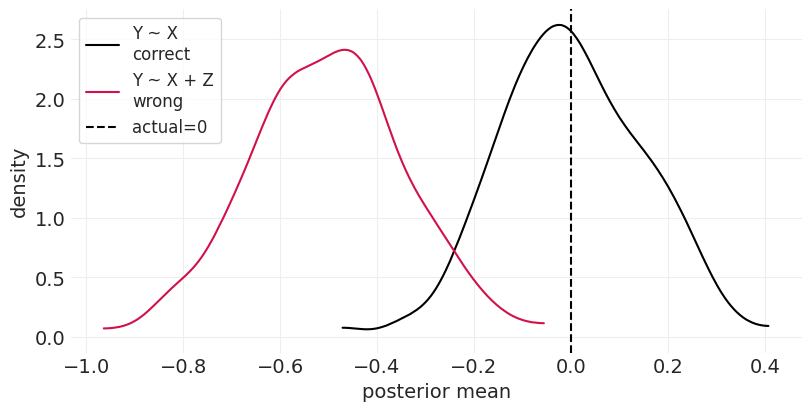

In [33]:
run_bad_mediator_simulation(beta_XZ=1, beta_ZY=0)

though there is no causal effect, you end up concluding a negative effect of X on Y

## Colliders & Descendants

Generally, **Avoid the Collider**!

Adding descendants of the target variable is almost always a terrible idea, because your selecting groups based on the outcome. This is known as **Case Control Bias** (selection on outcome)

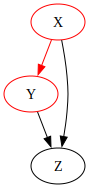

In [34]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("X", "Z"),
        ("Y", "Z")
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    }
)

Colliders not always so obvious

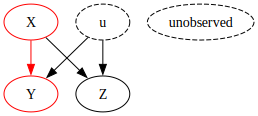

In [35]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("X", "Z"),
        ("u", "Y"),
        ("u", "Z"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    }
)

Collider is formed by unobserved variable u

### Bad Descendent: Selection on Outcome (Case Control Bias)

Stratifying on a variable affected by the outcome is a **very bad** practice.
- reduces variation in $Y$ that could have been explained by $X$

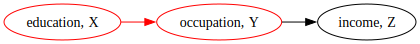

In [36]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Y", "Z"),
    ],
    node_props={
        "X": {"color": "red", "label": "education, X"},
        "Y": {"color": "red", "label": "occupation, Y"},
        "Z": {"label": "income, Z"},
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

#### Verify via simulation:

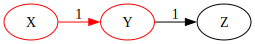

In [37]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Y", "Z"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "1"},
        ("Y", "Z"): {"label": "1"}
    },
    graph_direction="LR"
)

In [68]:
def simulate_case_control_bias(beta_XY = 1, beta_YZ = 1, n_samples = 100):
    # independent variables
    X = stats.norm.rvs(size=n_samples)
    
    # causal effect of X on Y
    mu_Y = X * beta_XY
    Y = stats.norm.rvs(loc=mu_Y, size=n_samples)
    
    # causal effect of Y on Z
    mu_Z = Y * beta_YZ
    Z = stats.norm.rvs(loc=mu_Z, size=n_samples)
    
    # put data into format for statsmodels
    data = pd.DataFrame(
        np.vstack([Y, X, Z]).T,
        columns=['Y', 'X', 'Z']
    )
    
    unstratified_model = smf.ols('Y ~ X', data=data).fit()
    stratified_model = smf.ols('Y ~ X + Z', data=data).fit()
    
    return unstratified_model.params.X, stratified_model.params.X

def run_case_control_simulation(beta_XY=1, beta_YZ=1, n_simulations=500, n_samples_per_simulation=100):
    beta_X = beta_XY
    
    simulations = np.array(
        [
            simulate_case_control_bias(beta_XY=beta_XY, beta_YZ=beta_YZ, n_samples=n_samples_per_simulation)
            for _ in range(n_simulations)
        ]
    )
    
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color='C0', ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel('posterior mean')
    plt.ylabel('density')

#### Descendant explains away some of he causal effect of $X$ on $Y$
The estimated causal effect has been reduced because the descendent reduces the variation in $Y$ that can can be explained by $X$

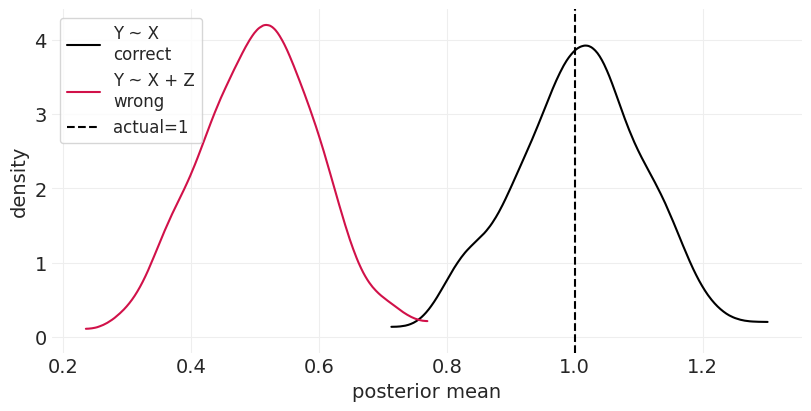

In [69]:
run_case_control_simulation(beta_XY=1, beta_YZ=1)

### Removing Descendent effect by setting $\beta_{YZ}=0$
The descendant no longer has any effect here, so we should recover the same (correct) inference for both stratified and unstratified models

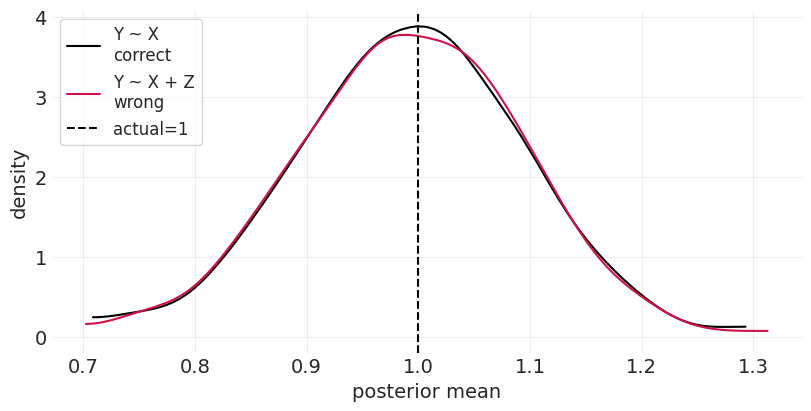

In [48]:
run_case_control_simulation(beta_XY=1, beta_YZ=0)

### Bad Ancestor (aka precision parasite)

Now $Z$ is a parent of $X$

- no backdoor path, $X$ is directly connected to $Y$
- when stratifying by $Z$ you're explaining away variation in $X$, thus reducing the amount of causal information between $X$ and $Y$ that can be explained otherwise.
- **Does not bias your estimate,** but it  **reduces precision**, so estimates will have more uncertainty

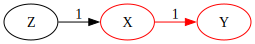

In [49]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "1"},
        ("Z", "X"): {"label": "1"}
    },
    graph_direction="LR"
)

#### Verify via simulation

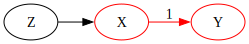

In [50]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "1"},
        ("Y", "Z"): {"color": "red", "label": "1"}
    },
    graph_direction="LR"
)

In [78]:
np.random.seed(123)
def simulate_bad_ancestor(beta_ZX=1, beta_XY=1, unobserved_variance=None, n_samples=100):
    Z = stats.norm.rvs(size=n_samples)
    
    mu_X = Z * beta_ZX
    if unobserved_variance is not None:
        u = stats.norm.rvs(size=n_samples) * unobserved_variance
        mu_X += u
    
    X = stats.norm.rvs(size=n_samples, loc=mu_X)
    
    mu_Y = X * beta_XY
    if unobserved_variance is not None:
        mu_Y += u
    
    Y = stats.norm.rvs(size=n_samples, loc=mu_Y)
    
    data = pd.DataFrame(
        np.vstack([X, Y, Z]).T,
        columns=['X', 'Y', 'Z']
    )
    
    non_stratified_model = smf.ols('Y ~ X', data=data).fit()
    stratified_model = smf.ols('Y ~ X + Z', data=data).fit()
    
    return non_stratified_model.params.X, stratified_model.params.X

def run_bad_ancestor_simulation(beta_ZX=1, beta_XY=1, n_simulations=500, unobserved_variance=None, n_samples_per_simulations=100):
    beta_X = beta_XY
    
    simulations = np.array(
        [
            simulate_bad_ancestor(
                beta_ZX=beta_ZX,
                beta_XY=beta_XY,
                unobserved_variance=unobserved_variance,
                n_samples=n_samples_per_simulations
            )
            for _ in range(n_simulations)
        ]
    )
    _, ax = plt.subplots(figsize=(8, 4))
    az.plot_dist(simulations[:, 0], label='Y ~ X\ncorrect', color='black', ax=ax)
    az.plot_dist(simulations[:, 1], label='Y ~ X + Z\nwrong', color='C0', ax=ax)
    plt.axvline(beta_X, color='k', linestyle='--', label=f'actual={beta_X}')
    plt.legend(loc='upper left')
    plt.xlabel('posterior mean')
    plt.ylabel('density');

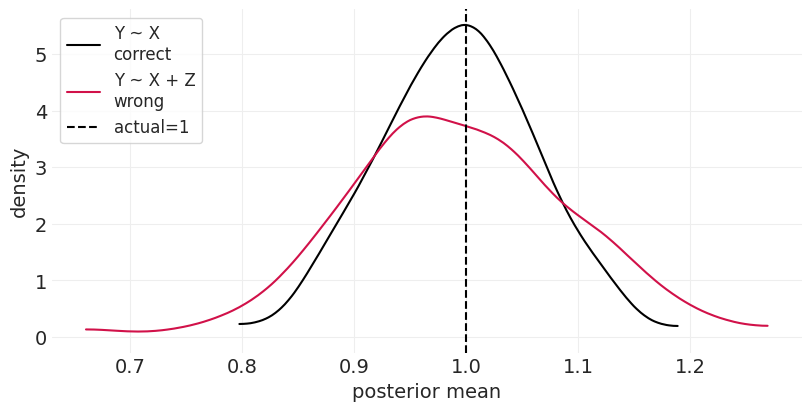

In [73]:
run_bad_ancestor_simulation()

Stratifying by Z doesn't add bias (it's centered on the correct value), but it does increase variance in estimator. This reduction in precision is proportional to the magnitude of the causal relationship between Z and X

#### Increasing the relationship between Z and X further reduces precision

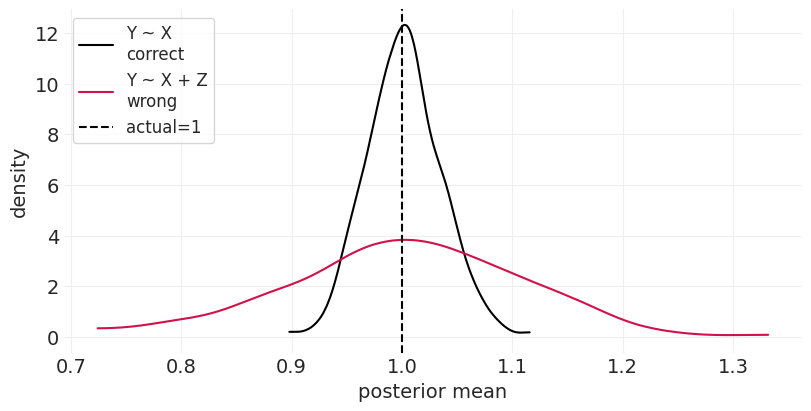

In [74]:
run_bad_ancestor_simulation(beta_ZX=3)

## Bias Amplification

Stratifying on an ancestor when there are other confounders, particularly unobserved forks. **This is like the Bias Parasite scenario, but it also adds bias.**

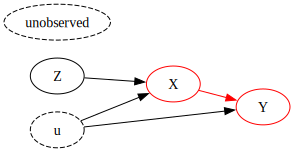

In [75]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
        ("u", "X"),
        ("u", "Y")
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Y"): {"color": "red"},
        ("Y", "Z"): {"color": "red"}
    },
    graph_direction="LR"
)

### Verify via simulation

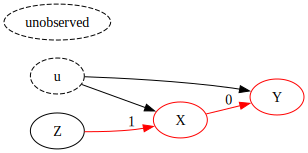

In [76]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("Z", "X"),
        ("u", "X"),
        ("u", "Y")
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"},
        "u": {"style": "dashed"},
        "unobserved": {"style": "dashed"},
    },
    edge_props={
        ("X", "Y"): {"color": "red", "label": "0"},
        ("Z", "X"): {"color": "red", "label": "1"}
    },
    graph_direction="LR"
)

#### Run simulation with no actual causal effect, $\beta_{XY} = 0$

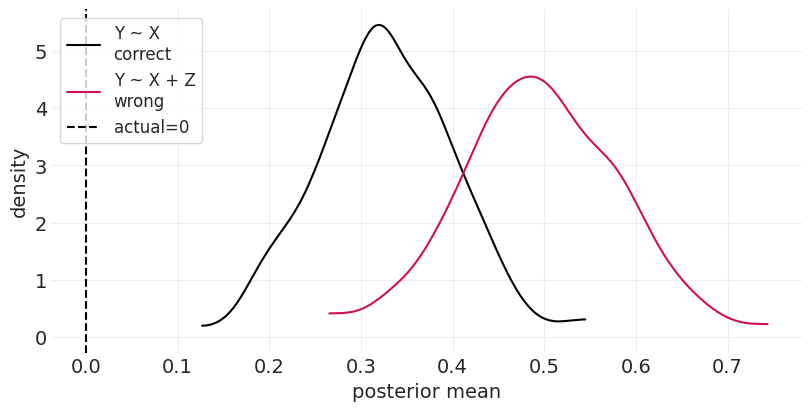

In [79]:
run_bad_ancestor_simulation(beta_ZX=1, beta_XY=0, unobserved_variance=1)


Above we see that both estimators are biased -- even in the best case, we can't observe, and thus control for the confound $u$. But when stratifying by the ancestor, this are MUCH WORSE.

Hand-wavy explanation:
- in order for $X$ and $Y$ to be associated, their causes need to be associated
- by stratifying by $Z$, we remove the amount of variation in $X$ that is caused by $Z$
- this reduction in variation in $X$ makes the confound $U$ more important comparatively

### Disrete example of bias amplificiation

In [83]:
def simulate_discrete_bias_amplifications(beta_ZX=1, beta_XY=1, n_samples=1000):
    Z = stats.bernoulli.rvs(p=.5, size=n_samples)
    u = stats.norm.rvs(size=n_samples)
    
    mu_X = beta_ZX * Z + u
    X = stats.norm.rvs(loc=mu_X, size=n_samples)
    
    mu_Y = beta_XY * X + u
    Y = stats.norm.rvs(loc=mu_Y, size=n_samples)
    
    data = pd.DataFrame(
        np.vstack([u, Z, X, Y]).T,
        columns=['u', 'Z', 'X', 'Y']
    )
    
    models = {}
    models['unstratified'] = smf.ols('Y ~ X', data=data).fit()
    models['z=0'] = smf.ols('Y ~ X', data=data[data.Z == 0]).fit()
    models['z=1'] = smf.ols('Y ~ X', data=data[data.Z == 1]).fit()
    
    return models, data

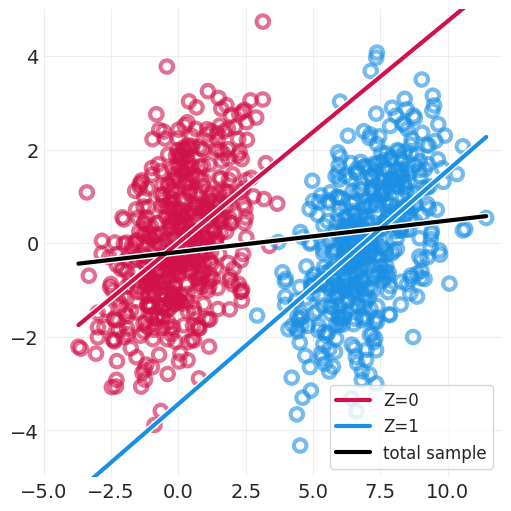

In [90]:
beta_ZX = 7
beta_ZY = 0
models, data = simulate_discrete_bias_amplifications(beta_ZX=beta_ZX, beta_XY=beta_XY)

fig, axs = plt.subplots(figsize=(5, 5))

def plot_linear_model(model, color, label):
    params = model.params
    xs = np.linspace(data.X.min(), data.X.max(), 10)
    ys = params.Intercept + params.X * xs
    utils.plot_line(xs, ys, color=color, label=label)
    
for z in [0, 1]:
    color = f'C{z}'
    utils.plot_scatter(data.X[data.Z==z], data.Y[data.Z==z], color=color)
    model = models[f'z={z}']
    plot_linear_model(model, color=color, label=f'Z={z}')
    
model = models['unstratified']
plot_linear_model(model, color='k', label=f"total sample")

plt.xlim([-5, 12])
plt.ylim([-5, 5])
plt.legend();

- When ignoring Z (the ancestor), the estimate is still somewhat biased (i.e. the black slope is not flat, as it should be for $\beta_{XY} = 0$)
- but it's not nearly as bad as the individual slopes (blue/red) when stratifying by Z

# Review: Good & Bad Controls
- **Confound**: estimator design or sample that "confoudnds" or "confuses" our causal estimate
- **Control**: variable added to the analysis to that a causal estimate is possible
- Adding controls can often be worse than ommitting them
- Make assumptions explicit, and use backdoor criterion to verify those assumptions

**You have to do scientific modeling to do scientific analysis**

# BONUS: The Table 2 Fallacy
- Not all coefficients represent causal effects, particularly those in the adjustment set
- Those that _are_ causal effects tend to be partial effects, not total causal effects.
- Table 2 actively _encourage_ misinterpretation
- As mentioned multiple times: **Need different estimators for addressing different causal effects.**

## Example: Smoking, Age, HIV, and Stroke

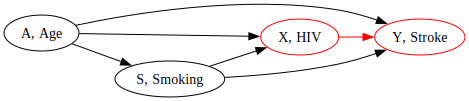

In [91]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("S", "Y"),
        ("S", "X"),
        ("A", "Y"),
        ("A", "X"),
        ("A", "S"),
    ],
    node_props={
        "X": {"label": "X, HIV", "color": "red"},
        "Y": {"label": "Y, Stroke", "color": "red"},
        "S": {"label": "S, Smoking"},
        "A": {"label": "A, Age"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

### Identify paths via backdoor criterion
- $X \rightarrow Y$ (front door)
- $X \leftarrow S \rightarrow Y$ (backdoor, fork)
- $X \leftarrow A \rightarrow Y$ (backdoor, fork)
- $X \leftarrow A \rightarrow S \rightarrow Y$ (backdoor, fork and pipe)

Adjustment set is $\{S, A\}$

### Conditional Statistical Model

$$
\begin{align*}
Y_i &\sim \mathcal{N}(\mu_i, \sigma) \\
\mu_i = &\alpha + \beta_X X_i + \beta_S S_i + \beta_A A_i
\end{align*}
$$

### Looking at the model "from the perspective of various variables"
#### From perspective of X
Conditioning on $A$ and $S$ essentially removes the arrows going into $X$, $\beta_X$ giving us the **direct effect** of $X$ on $Y$
  - we've removed all backdoor paths by stratifying by $S$ and $A$ throught the coefficients $\beta_S, \beta_A$

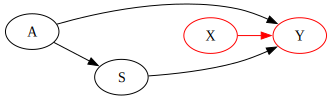

In [92]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("S", "Y"),
        ("S", "X"),
        ("A", "Y"),
        ("A", "X"),
        ("A", "S"),
    ],
    node_props={
        "X": {"color": "red"},
        "Y": {"color": "red"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"},
        ("A", "X"): {"color": "none"},
        ("S", "X"): {"color": "none"}
    },
    graph_direction="LR"
)

#### From perspective of S

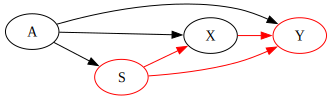

In [93]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("S", "Y"),
        ("S", "X"),
        ("A", "Y"),
        ("A", "X"),
        ("A", "S"),
    ],
    node_props={
        "Y": {"color": "red"},
        "S": {"color": "red"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"},
        ("S", "X"): {"color": "red"},
        ("S", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

#### Adjusted graph with the full model

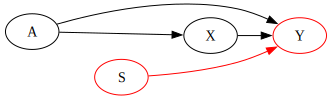

In [94]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("S", "Y"),
        ("S", "X"),
        ("A", "Y"),
        ("A", "X"),
        ("A", "S"),
    ],
    node_props={
        "Y": {"color": "red"},
        "S": {"color": "red"}
    },
    edge_props={
        ("S", "X"): {"color": "none"},
        ("A", "S"): {"color": "none"},
        ("S", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

- In the unconditional model, the effect of $S$ on $Y$ is confounded by $A$, because it's a common cause of $S$ and $Y$ (and $X$)
- Conditioning on $A$ & $X$ (via the same statistical model above), $\beta_{S}$ gives the **direct effect** of $S$ on $Y$/
  - Since we've blocked the path along $X$ in the linear regression, we no longer get the **total effect**.

#### From the perspective of A

In the unconditional model, the **total causal effect** of $A$ on $Y$ flows through all paths:

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


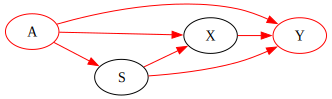

In [95]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("S", "Y"),
        ("S", "X"),
        ("A", "Y"),
        ("A", "X"),
        ("A", "S"),
    ],
    node_props={
        "Y": {"color": "red"},
        "A": {"color": "red"}
    },
    edge_props={
        ("X", "Y"): {"color": "red"},
        ("A", "X"): {"color": "red"},
        ("A", "Y"): {"color": "red"},
        ("A", "S"): {"color": "red"},
        ("S", "X"): {"color": "red"},
        ("S", "Y"): {"color": "red"}
    },
    graph_direction="LR"
)

- Conditioning on $S$ & $X$ (via the same statistical model above), $\beta_{S}$ gives the **direct effect** of $S$ on $Y$/
  - Since we've blocked the path along $X$ in the linear regression, we no longer get the **total effect**.

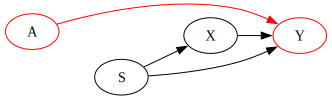

In [96]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Y"),
        ("S", "Y"),
        ("S", "X"),
        ("A", "Y"),
        ("A", "X"),
        ("A", "S"),
    ],
    node_props={
        "Y": {"color": "red"},
        "A": {"color": "red"}
    },
    edge_props={
        ("A", "X"): {"color": "none"},
        ("A", "S"): {"color": "none"},
        ("A", "Y"): {"color": "red"},
    },
    graph_direction="LR"
)

This gets trickier if we consider unobserved confounds on variables!

## Summary: Table 2 Fallacy
- Not all coefficients have the same interpretation
  - different estimands require different models
- Do not present coefficients as they are equal (i.e. in Table 2)
- ...or, don't present coefficients at all, instead push out predictions.
- Provide _explicit interpretation_ of each